# Prediction Check

## 제출 데이터 라벨 분포 확인하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

In [147]:
def load_data(model_name,model_detail):
    filepath = './output/'+model_name+'_'+model_detail+'.csv'
    return pd.read_csv(filepath)

In [194]:
df = load_data('KR-ELECTRA-discriminator','rm_noise')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './output/KR-ELECTRA-discriminator_rm_noise.csv'

## 시각화

### 라벨 분포

In [12]:
from pathlib import Path

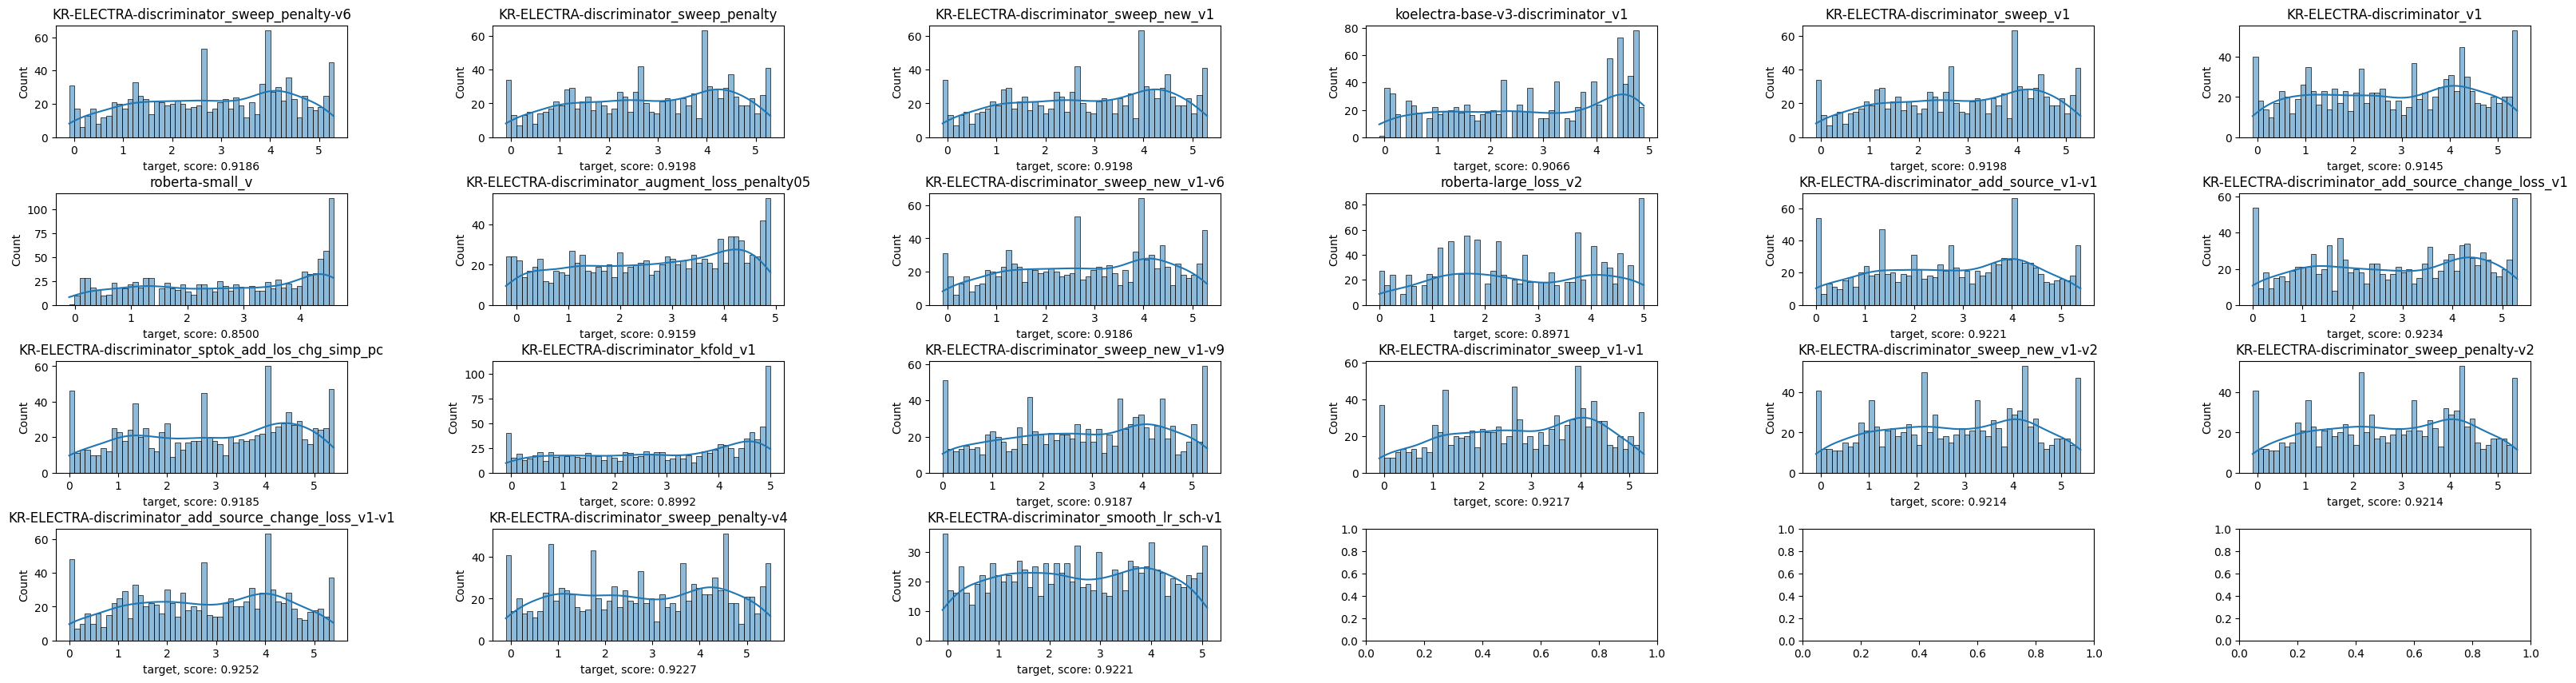

In [129]:
output_dir_files = list(Path('./output').iterdir())
score_files = [file for file in Path('scoreboard.txt').read_text().split('\n') if file != '']
score_dict={file.split(':')[0].strip():file.split(':')[1].strip() for file in score_files}

fig, axes = plt.subplots(4, 6, figsize=(40, 10))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, file in enumerate(output_dir_files):
    df = pd.read_csv(file)
    sns.histplot(data=df, x='target', bins=50, ax=axes[i], kde=True)

    axes[i].set_title(file.name[:-4])
    axes[i].set_xlabel('target, score: '+score_dict[file.name[:-4]])
        


In [358]:
df = pd.read_csv('ensemble_outputs/ensemble_output.csv')
# df = pd.read_csv('./val_output/KR-ELECTRA-discriminator_rm_noise.csv')

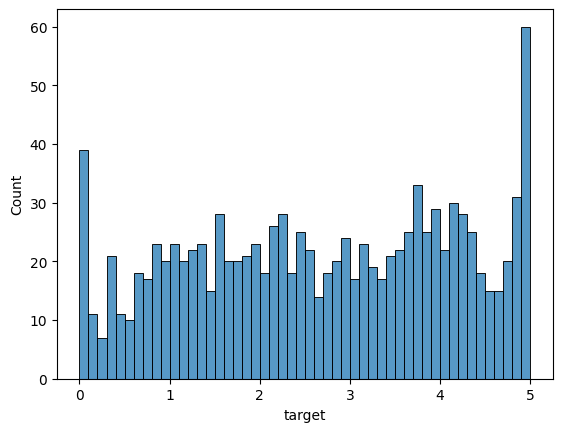

In [359]:
sns.histplot(x='target',data=df,bins=50)
plt.show()

## 검증 데이터 '실제' vs '예측'

### 하나의 Dataframe으로 만들기

In [10]:
### 모델 로드

# 모델 name, detail 정의
model_name='KR-ELECTRA-discriminator'
model_detail='augment_v3_loss_penalty05'

# 모델 이름
# augment_loss_penalty05
# smooth_lr_sch-v1
# augment_v2_loss_penalty0
# augment_v3_loss_penalty05
# rm_noise_s2_2

In [7]:
def load_total_data(model_name,model_detail,full_name=None):
    
    val_filepath = './data/dev.csv'
    if full_name:
        val_output_filepath = full_name
    else:
        val_output_filepath = './val_output/'+model_name+'_'+model_detail+'.csv'

    df_val=pd.read_csv(val_filepath)
    df_val_output=pd.read_csv(val_output_filepath)
    
    df_val_output=df_val_output.rename(columns={'target':'predict'})

    df_val_output['target']=df_val['label']
    df_val_output['binary_target']=df_val['binary-label']

    df_val_output['sent1']=df_val['sentence_1']
    df_val_output['sent2']=df_val['sentence_2']
    
    df_val_output=df_val_output.drop(columns=['id'])

    output_df=df_val_output[['sent1','sent2','predict','target','binary_target']]

    return output_df

In [300]:
df = load_total_data(model_name,model_detail)
df.head(10)

,sent1,sent2,predict,target,binary_target
0,액션은개뿔 총몇번쏘고 끝입니다,액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리,1.5,2.0,0.0
1,감격스러워 입막으심?,너무 감동해서 입 다물어?,3.4,3.4,1.0
2,이번 년도에 본 영화 중 가장 최악의 영화......,올해 본 영화 중 최악...,4.4,4.0,1.0
3,특히 평소 뮤직채널에 많은 영감을 불어넣어주시는!,"특히, 당신은 항상 많은 음악 채널에 영감을 줍니다!",3.8,3.4,1.0
4,다음 밥스테이지가 기대됩니다~ ㅎ,다음 후기도 기대됩니다~~,1.6,1.4,0.0
5,사진 간지.. ㅋㅋ 축하드립니다,사진이 나왔어요..ㅋㅋㅋ 축하드립니다.,3.0,2.4,0.0
6,영화보면서 기분전환이 되었어요,영화 보는 내내 뭔가 모를 편안함을 느꼈어요,1.9,2.0,0.0
7,건강하게 자라기를!!,얼른 건강 회복하기를요!!!,1.0,1.2,0.0
8,고수님들의 많은 가르침 부탁드립니다 <PERSON>,고수님들의 많은 지도 부탁드립니다 <PERSON>,4.4,4.6,1.0
9,러닝화 신었더니 뒤꿈치가 푹신해서 자꾸 앞으로 힘이 쏠리고 뒤꿈치 들리네요,런닝화를 신고 발 뒤꿈치가 부드러워서 계속 힘을 빼고 발뒤꿈치를 들어 올렸다.,3.2,3.0,1.0


### 예측 라벨 vs 실제 라벨 분포

histplot 분포

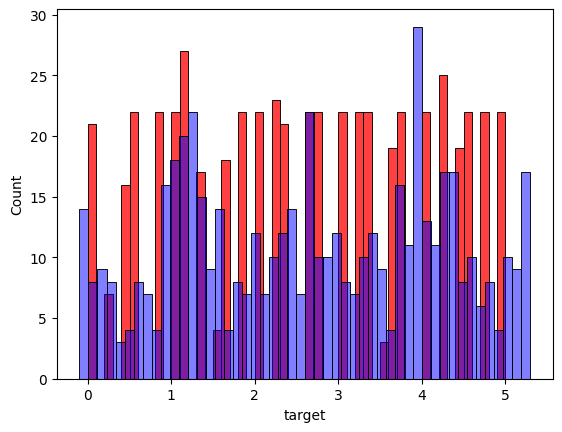

In [301]:
sns.histplot(x='target',data=df,bins=50,color='r')
sns.histplot(x='predict',data=df,bins=50,color='b',alpha=0.5)
plt.show()

산점도 분포

In [2]:
# Error Gap 설정
error_gap=1.5

In [4]:
def extract_error_data(df,error_gap:int=2.0):
    df_error=df[np.abs((df['predict']-df['target']))>error_gap]
    df_close=df[np.abs((df['predict']-df['target']))<=error_gap]
    return df_error, df_close

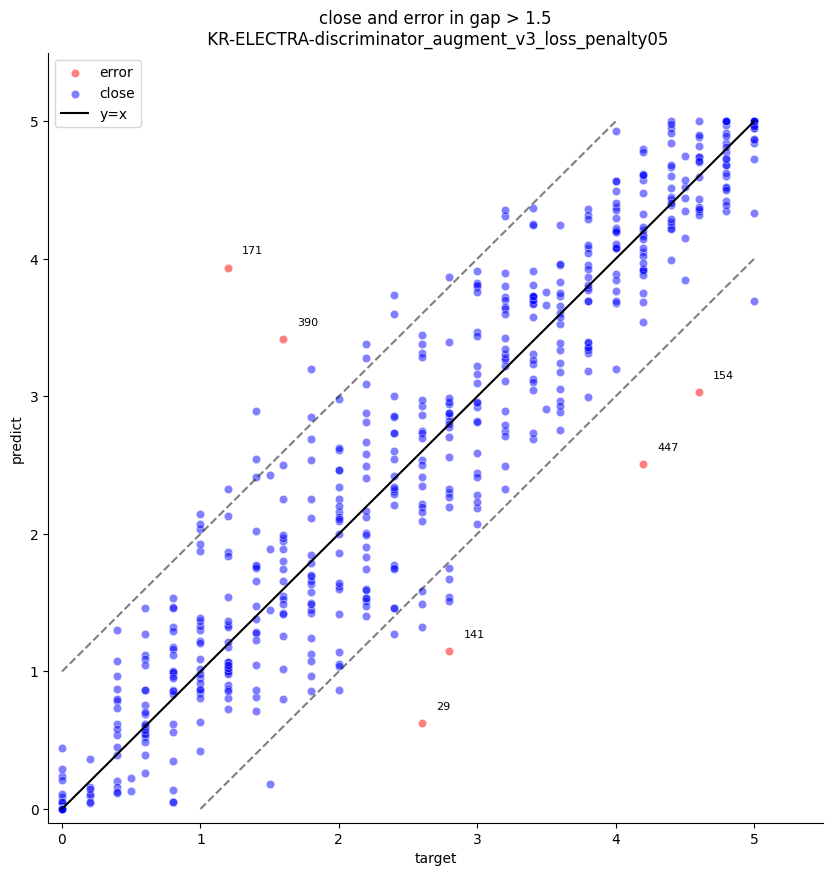

In [11]:
# dataload
df = load_total_data(model_name,model_detail,full_name='./val_output/2_val_ensemble_output.csv')

# error_df, close_df 추출
error_df, close_df = extract_error_data(df,error_gap=error_gap)

# 산점도 확인
plt.figure(figsize=(10,10))
sns.scatterplot(x='target',y='predict',data=error_df,color='r',alpha=0.5)
for idx in error_df.index:
    plt.text(error_df['target'][idx] + 0.1, error_df['predict'][idx]+0.1, idx ,fontsize=8)

sns.scatterplot(x='target',y='predict',data=close_df,color='b',alpha=0.5 )
sns.lineplot(x=[0,5],y=[0,5],color='black')
sns.lineplot(x=[0,4],y=[1,5],color='black',linestyle='--',alpha=0.5)
sns.lineplot(x=[1,5],y=[0,4],color='black',linestyle='--',alpha=0.5)

plt.xlim(-0.1,5.5)
plt.ylim(-0.1,5.5)
plt.title('close and error in gap > '+str(error_gap)+f'\n {model_name}_{model_detail}')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(['error','close','y=x'])
plt.show()

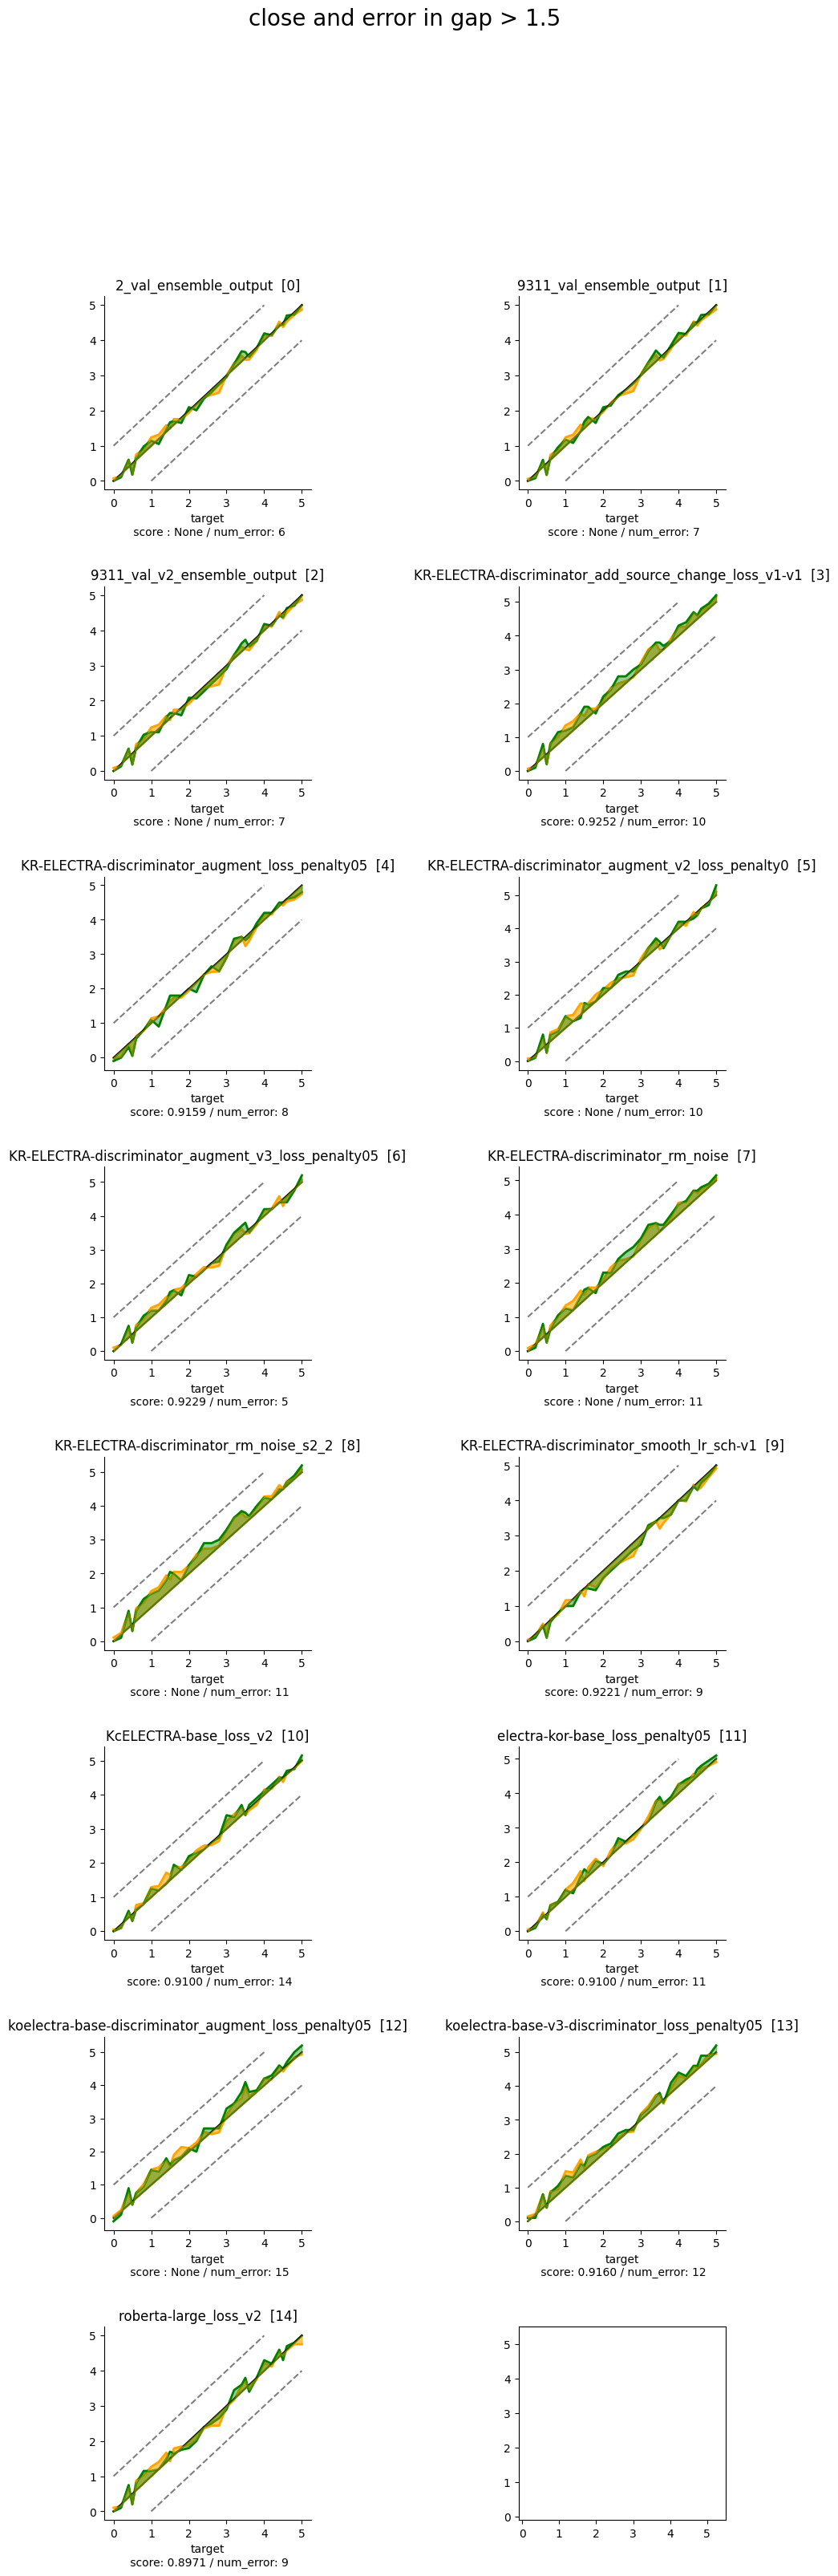

In [229]:
### 산점도 분포 비교

# 각 라벨별 평균에 대한 분포만 보고싶다면
only_mean = True

# 파일 불러오기
output_dir_files = list(sorted(Path('./val_output').iterdir()))
score_files = [file for file in Path('scoreboard.txt').read_text().split('\n') if file != '']
score_dict={file.split(':')[0].strip():file.split(':')[1].strip() for file in score_files}

fig, axes = plt.subplots(8, 2, figsize=(10, 36))
axes = axes.flatten()
plt.subplots_adjust(wspace=1, hspace=0.5)
plt.suptitle(f'close and error in gap > {error_gap}',fontsize=20)

for i, file in enumerate(output_dir_files):
    df = load_total_data(model_name,model_detail,file)
    
    predict_mean_by_target = df.groupby('target')['predict'].mean()
    predict_median_by_target = df.groupby('target')['predict'].median()

    # error_df, close_df 추출
    error_df, close_df = extract_error_data(df,error_gap=error_gap)

    # 산점도 확인
    if not only_mean:
        sns.scatterplot(x='target',y='predict',data=error_df,color='r',alpha=0.5,ax = axes[i])
        for idx in error_df.index:
            axes[i].text(error_df['target'][idx] + 0.1, error_df['predict'][idx]+0.1, idx ,fontsize=8)
        sns.scatterplot(x='target',y='predict',data=close_df,color='b',alpha=0.5,ax = axes[i] )
    sns.lineplot(x=[0,5],y=[0,5],color='black',ax = axes[i],zorder=2)
    sns.lineplot(x=[0,4],y=[1,5],color='black',ax = axes[i],linestyle='--',alpha=0.5)
    sns.lineplot(x=[1,5],y=[0,4],color='black',ax = axes[i],linestyle='--',alpha=0.5)

    # 각 라벨별 평균에 대한 분포확인
    sns.lineplot(x=predict_mean_by_target.index,y=predict_mean_by_target.values,color='orange',ax=axes[i],linewidth=2,zorder=1)
    axes[i].fill_between(x=predict_mean_by_target.index,y1=predict_mean_by_target.index, y2=predict_mean_by_target.values, color='orange', alpha=0.6,zorder=3)

    # 각 라벨별 중앙값에 대한 분포확인
    sns.lineplot(x=predict_median_by_target.index,y=predict_median_by_target.values,color='green',ax=axes[i],linewidth=2,zorder=1)
    axes[i].fill_between(x=predict_median_by_target.index,y1=predict_median_by_target.index, y2=predict_median_by_target.values, color='green', alpha=0.4,zorder=3)

    plt.xlim(-0.1,5.5)
    plt.ylim(-0.1,5.5)

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    if not only_mean:
        fig.legend(['error','close','y=x'])
    
    axes[i].set_title(file.name[:-4]+f"  [{i}]")
    if file.name[:-4] in score_dict:
        axes[i].set_xlabel('target\n score: '+score_dict[file.name[:-4]]+f' / num_error: {len(error_df.index)}')
    else:
        axes[i].set_xlabel('target\n score : None'+f' / num_error: {len(error_df.index)}')
    

In [227]:
# 섞고자 하는 모델의 번호들 리스트로 전달하면, 모델이 섞인 분포를 보여줌
def mix_outputs(nums,weight=[]):
    len_nums = len(nums)
    
    if weight==[]:
        weight = [1/len_nums]*len_nums
    else:
        weight = weight/np.sum(weight)


    df = load_total_data(model_name,model_detail,output_dir_files[nums[0]])
    total_mean = df.groupby('target')['predict'].mean()*weight[0]
    total_median = df.groupby('target')['predict'].median()*weight[0]
    
    for i,num in enumerate(nums[1:],start=1):
        df = load_total_data(model_name,model_detail,output_dir_files[num])
        total_mean += df.groupby('target')['predict'].mean()*weight[i]
        total_median += df.groupby('target')['predict'].median()*weight[i]
    
    plt.figure(figsize=(10,10))
    plt.axis('equal')

    sns.lineplot(x=[0,5],y=[0,5],color='black',zorder=2)
    sns.lineplot(x=[0,4],y=[1,5],color='black',linestyle='--',alpha=0.5)
    sns.lineplot(x=[1,5],y=[0,4],color='black',linestyle='--',alpha=0.5)

    # 각 라벨별 평균에 대한 분포확인
    sns.lineplot(x=total_mean.index,y=total_mean.values,color='orange',linewidth=2,zorder=1)
    plt.fill_between(x=total_mean.index,y1=total_mean.index, y2=total_mean.values, color='orange', alpha=0.6,zorder=3)
    
    # 각 라벨별 중앙값에 대한 분포확인
    sns.lineplot(x=total_median.index,y=total_median.values,color='green',linewidth=2,zorder=1)
    plt.fill_between(x=total_median.index,y1=total_median.index, y2=total_median.values, color='green', alpha=0.4,zorder=3)

    
    top_k = 3
    mean_gap_top_k=(np.abs(total_mean-sorted(total_mean.index.tolist()))).sort_values(ascending=False).iloc[:top_k]
    mean_gap_top_k = list(zip(mean_gap_top_k.index, mean_gap_top_k.values))
    string_mean_gap_top_k = '\n'.join([f'[ target : {i[0]} ], [ error : {i[1]:.2f} ]' for i in mean_gap_top_k])

    median_gap_top_k=(np.abs(total_median-sorted(total_median.index.tolist()))).sort_values(ascending=False).iloc[:top_k]
    median_gap_top_k = list(zip(median_gap_top_k.index, median_gap_top_k.values))
    string_median_gap_top_k = '\n'.join( [f'[ target : {i[0]} ], [ error : {i[1]:.2f} ]' for i in median_gap_top_k])

    plt.text(5.5,3.5,f'< mean_gap_top_{top_k} >\n\n{string_mean_gap_top_k}',fontsize=15, color='orange')
    plt.text(5.5,1.5,f'< median_gap_top_{top_k} >\n\n{(string_median_gap_top_k)}',fontsize=15,color='green')

    plt.xlim(-0.1,5.5)
    plt.ylim(-0.1,5.5)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title(f'mix {nums} models',fontsize=20)

    plt.show()
    

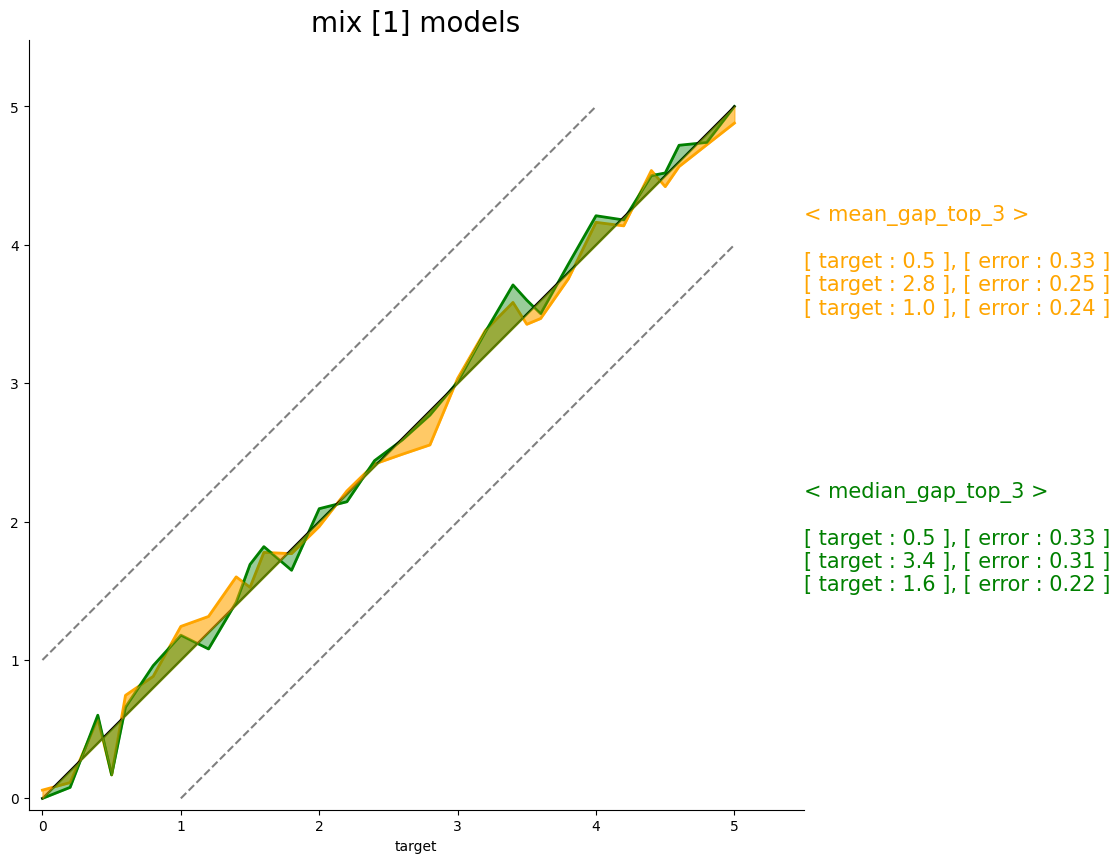

In [228]:
mix_outputs([1],[])

### 예측 값과 실제 값이 큰 샘플들 보기

In [211]:
df_error,_=extract_error_data(df,error_gap)
print(f'error 데이터 개수 : {len(df_error)}')
df_error

error 데이터 개수 : 11


,sent1,sent2,predict,target,binary_target
29,엥 제가 2등인가요? ㅋㅋ,엥 은메달인가요 제가? ㅋㅋ,0.8,2.6,1.0
65,ㅋㅋ 실습까지 ㅋㅋ,ㅎㅎ 연습까지,3.5,1.8,0.0
130,국회의원 월급 삭감,국회의원 급여 미지급,3.5,1.8,0.0
141,분을 두시간으로 늘리고싶다면 이 영화를 추천.,인생에서 두시간을 쓰레기통에 버리고싶다면 보세요.,1.2,2.8,1.0
171,(선언만 해두고 차후에 적정시점 실행),(나중에 적절한 시점에 선언하고 실행하면 됨),4.1,1.2,0.0
288,과장과 공포에 굴복하여 도리어 국민생명을 위협하고 있는 비이성적인 '독일 따라하기'...,과장과 공포에 굴복하여 국민의 생명을 위협하는 불합리한 '독일을 모방'하는 비핵화 ...,4.1,2.4,0.0
390,편보다 편이 더 재밌는 영화... 편부터는 보지마,본편보다 영화가 더 재밌어... 본편은 보지마,3.6,1.6,0.0
447,자브라 대만족이죠!,Jabra에 매우 만족합니다!,2.5,4.2,1.0
454,갈수록 뛰는 시간이 늘 것 같은 설렘!!,러닝타임이 길어질수록 더해지는 것 같은 설렘!!,4.2,2.2,0.0
528,ㅋㅋ너무 재밌었어요!!!,다시 봐도 너무 웃겨요ㅋㅋ,3.3,1.4,0.0


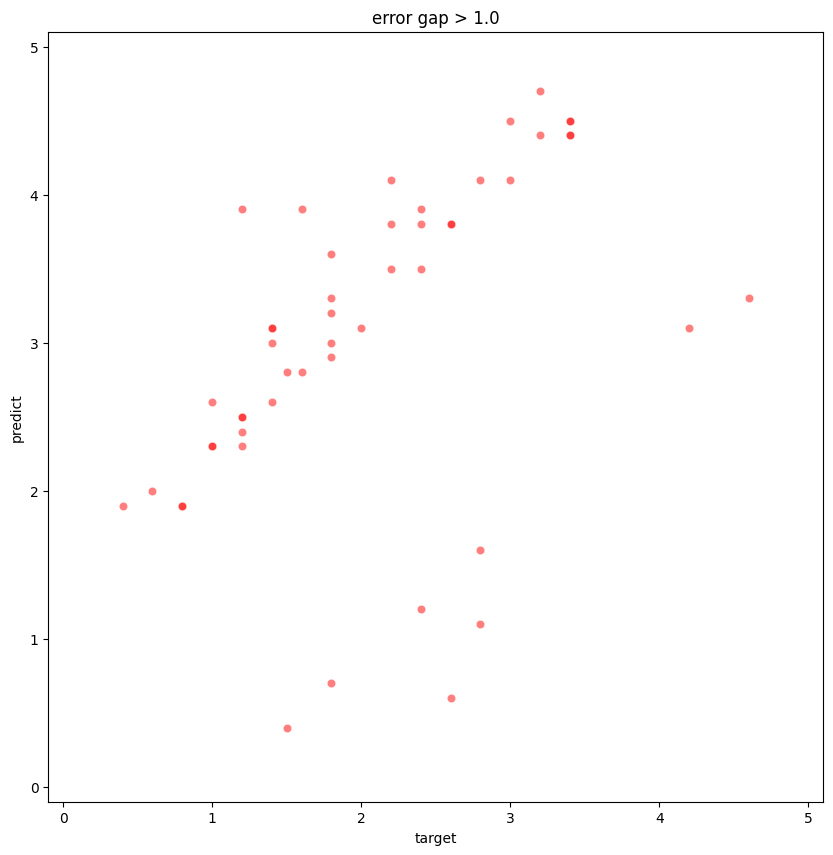

In [191]:
# 산점도 확인
plt.figure(figsize=(10,10))
sns.scatterplot(x='target',y='predict',data=df_error,color='r',alpha=0.5 )

plt.xlim(-0.1,5.1)
plt.ylim(-0.1,5.1)
plt.title('error gap > '+str(error_gap))

plt.show()

### 실제 val에 있는 해당 라벨의 개수와, 틀린 개수 비교

생각해봐야할 것
- 에러가 많이 안나온 경우를 단순히 잘 맞춘 경우라고 생각하면 x
- 검증 데이터에 해당 data 개수가 작은 경우 다 틀리더라도 틀린 개수가 적음
- 그래서 검증 데이터의 분포를 보며 확인해야 함

In [192]:
val_df= pd.read_csv('./data/dev.csv')

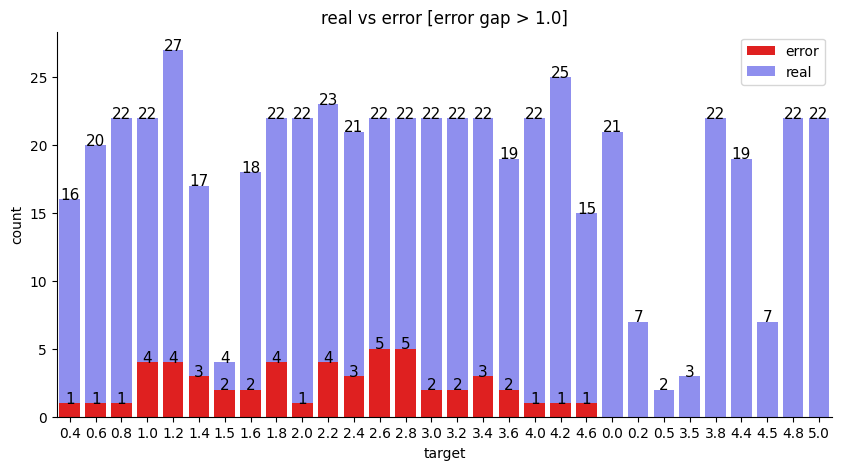

In [207]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x='target',data=df_error,color='r',zorder=2)
ax=sns.countplot(x='label',data=val_df,color='b',alpha=0.5)

plt.title('real vs error [error gap > '+str(error_gap)+']')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{int(p.get_height())}',
            ha='center', va='baseline', fontsize=11, color='black')

plt.legend(['error','real'])
plt.show()

In [84]:
# dev 데이터셋의 label 개수에 대한 error 데이터셋의 개수가 차지하는 비율이 threshold% 이상인 label만 추출

def extract_fatal_error_label(df_error,df_val,threshold=0.1):
    error_label_count=df_error['target'].value_counts()
    val_label_count=df_val['label'].value_counts()
    
    error_label_ratio=error_label_count/val_label_count
    error_label_ratio=error_label_ratio.sort_index()
    
    error_label_ratio=error_label_ratio[error_label_ratio>threshold]
    
    return error_label_ratio

In [85]:
fatal_label = extract_fatal_error_label(df_error,val_df,threshold=0.4)
fatal_label

Series([], Name: count, dtype: float64)

In [26]:
train_df=pd.read_csv('./data/train.csv')
train_labels = train_df['label'].value_counts()
for label in fatal_label.index:
    print(f'학습 데이터 내 {label}의 개수 : {train_labels[label]}')

- 얘내를 잘 못맞추는 듯 하니, 문장 앞뒤를 바꾼 데이터를 학습에 추가시켜볼까?
    - 비교해볼 필요가 있음
        - 생으로 데이터 2배
        - 1.5배
        - 1.25배


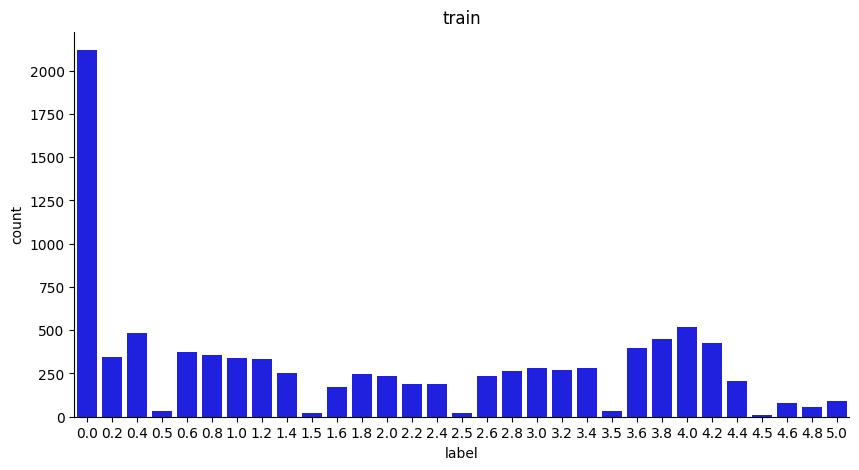

In [217]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',data=pd.read_csv('./data/train.csv'),color='b')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('train')
plt.show()